**Predicting bike rental demand to improve bikesharing operations**

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

file_path = '/content/drive/MyDrive/Data/Hour_train_validate.csv'
df = pd.read_csv(file_path)
print(df.head())

   instant      dteday   hr  weathersit  temp   atemp   hum  windspeed  \
0        1         NaN  0.0         1.0  9.84  14.395  81.0        0.0   
1        2         NaN  NaN         1.0  9.02  13.635  80.0        0.0   
2        3  2011-01-01  2.0         1.0  9.02  13.635  80.0        0.0   
3        4  2011-01-01  3.0         1.0  9.84  14.395  75.0        0.0   
4        5  2011-01-01  4.0         1.0  9.84  14.395  75.0        0.0   

   casual  registered   cnt  
0     3.0        13.0  16.0  
1     8.0        32.0  40.0  
2     5.0        27.0  32.0  
3     3.0        10.0  13.0  
4     0.0         1.0   1.0  


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13903 entries, 0 to 13902
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     13903 non-null  int64  
 1   dteday      13489 non-null  object 
 2   hr          13519 non-null  float64
 3   weathersit  13512 non-null  float64
 4   temp        13508 non-null  float64
 5   atemp       13478 non-null  float64
 6   hum         13496 non-null  float64
 7   windspeed   13529 non-null  float64
 8   casual      13534 non-null  float64
 9   registered  13473 non-null  float64
 10  cnt         13469 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.2+ MB
None
            instant            hr    weathersit          temp         atemp  \
count  13903.000000  13519.000000  13512.000000  13508.000000  13478.000000   
mean    6952.000000     11.558029      1.420071     20.473593     23.887736   
std     4013.594731      6.917390      0.643895      8

In [5]:
print("Missing Values:\n", df.isna().sum())

Missing Values:
 instant         0
dteday        414
hr            384
weathersit    391
temp          395
atemp         425
hum           407
windspeed     374
casual        369
registered    430
cnt           434
dtype: int64


In [6]:
df = df.dropna()
missing_values_after = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after)


Missing Values After Imputation:
 instant       0
dteday        0
hr            0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [6]:
'''
# Handling missing values
# date and hour: use the previous values
df = df.assign(dteday=df['dteday'].ffill().bfill())
df = df.assign(hr=df['hr'].ffill())

# countinuous variables: use the median values
for var in ['temp', 'atemp', 'hum', 'windspeed']:
    if df[var].isnull().sum() > 0:  # Check for missing values
        median_value = df[var].median()
        df[var] = df[var].fillna(median_value)

# count variables: use the mean values
for var in ['casual', 'registered', 'cnt']:
    if df[var].isnull().sum() > 0:  # Check for missing values
        mean_value = df[var].mean()
        df[var] = df[var].fillna(mean_value)

# categorical variables: use the mode values
for var in ['weathersit']:
    if df[var].isnull().sum() > 0:  # Check for missing values
        mode_value = df[var].mode()[0]  # Get the most frequent value
        df[var] = df[var].fillna(mode_value)

# Checking for missing values after imputation
missing_values_after = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after)


Missing Values After Imputation:
 instant       0
dteday        0
hr            0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


# Part1 : Linear Regression

## Q1.

Please estimate a linear regression model with cnt as the dependent variable and temp, hum, and windspeed as the independent variables. Interpret the coefficients of each predictor and explain their implications for bike rentals.

In [7]:
X = df[['temp', 'hum', 'windspeed']]
y = df['cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1270.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:45:58   Log-Likelihood:                -66273.
No. Observations:               10361   AIC:                         1.326e+05
Df Residuals:                   10357   BIC:                         1.326e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.3233      7.302     20.312      0.0

**1. Coefficients**
- Temperature (Coef = 8.48): For each 1-unit increase in temperature, bike rentals increase by 8.48 rentals. This strong positive relationship suggests higher rentals in warmer weather.
- Humidity (Coef = -2.46): For each 1-unit increase in humidity, rentals decrease by 2.46. Higher humidity likely deters bike rentals due to discomfort.
- Windspeed (Coef = 0.53): Each 1-unit increase in windspeed slightly increases rentals by 0.53. This effect is minor and may not have practical significance.

**2. Implications for Bike Rentals**
- Temperature and humidity have the most significant impacts on rentals. Warmer days increase demand, while humid conditions reduce it. Further factors could improve model accuracy.

## Q2.

Please create a variable named holiday to indicate if it is a US holiday for each observation. Estimate two different models:
Model 1: cnt as the dependent variable with temp, hum, and windspeed as independent variables.
Model 2: cnt as the dependent variable with temp, hum, windspeed, and holiday as independent variables. Conduct an F-test to determine if adding holiday significantly improves the model. Compare the R2 values of both models and explain what they indicate about model fit.

In [8]:
from datetime import datetime
!pip install holidays

import holidays
us_holidays = holidays.UnitedStates(years=[2011, 2012])

In [9]:
# Convert 'dteday' column to datetime if not already
df['dteday'] = pd.to_datetime(df['dteday'])

# Create 'holiday' variable
df['holiday'] = df['dteday'].apply(lambda x: 1 if x in us_holidays else 0)
print(df.head())

   instant     dteday   hr  weathersit   temp   atemp   hum  windspeed  \
2        3 2011-01-01  2.0         1.0   9.02  13.635  80.0     0.0000   
3        4 2011-01-01  3.0         1.0   9.84  14.395  75.0     0.0000   
4        5 2011-01-01  4.0         1.0   9.84  14.395  75.0     0.0000   
5        6 2011-01-01  5.0         2.0   9.84  12.880  75.0     6.0032   
9       10 2011-01-01  9.0         1.0  13.12  17.425  76.0     0.0000   

   casual  registered   cnt  holiday  
2     5.0        27.0  32.0        1  
3     3.0        10.0  13.0        1  
4     0.0         1.0   1.0        1  
5     0.0         1.0   1.0        1  
9     8.0         6.0  14.0        1  


In [10]:
# model 1
X1 = df[['temp', 'hum', 'windspeed']]
y = df['cnt']
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1270.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:14   Log-Likelihood:                -66273.
No. Observations:               10361   AIC:                         1.326e+05
Df Residuals:                   10357   BIC:                         1.326e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        148.3233      7.302     20.312      0.0

In [11]:
# model 2
X2 = df[['temp', 'hum', 'windspeed', 'holiday']]
y = df['cnt']
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     955.9
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:18   Log-Likelihood:                -66268.
No. Observations:               10361   AIC:                         1.325e+05
Df Residuals:                   10356   BIC:                         1.326e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.8942      7.316     20.490      0.0

In [12]:
# Conduct F-test
f_test = model1.compare_f_test(model2)
print("F-test results:", f_test)

F-test results: (10.24568641230882, nan, -1.0)


In [13]:
# Compare R Square values
r2_model1 = model1.rsquared
r2_model2 = model2.rsquared

print("Model 1 R-squared:", r2_model1)
print("Model 2 R-squared:", r2_model2)

if r2_model2 > r2_model1:
    print("Adding 'holiday' improves model fit.")
else:
    print("Adding 'holiday' does not improve model fit.")

Model 1 R-squared: 0.2689248760358357
Model 2 R-squared: 0.2696480938077751
Adding 'holiday' improves model fit.


**Implication**

Adding `holiday` slightly increases the R-squared from 0.269 in model1 to 0.270 in model2**, indicating a very modest improvement in model fit. This suggests `holiday` has a small impact on bike rentals but doesn’t substantially improve the model’s explanatory power.

## Q3.

Please estimate a linear regression model with cnt as the dependent variable and weathersit, holiday and interaction term between them as the independent variables. Please interpret the coefficients. What do these coefficients tell you about the relationship between weather conditions or holiday and bike rentals?

In [14]:
df['weathersit_holiday'] = df['weathersit'] * df['holiday']
X = df[['weathersit', 'holiday', 'weathersit_holiday']]
y = df['cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     88.79
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.01e-56
Time:                        12:46:27   Log-Likelihood:                -67764.
No. Observations:               10361   AIC:                         1.355e+05
Df Residuals:                   10357   BIC:                         1.356e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                233.6315      4

**1. Coefficients**
- Weather Situation (weathersit = -40.65): Poor weather conditions reduce bike rentals by 40.65 on average, suggesting that unfavorable weather significantly decreases demand.
- Holiday (holiday = -62.00): On holidays, bike rentals decrease by 62 on average, indicating a reduction in demand on holidays.
- Weather and Holiday Interaction (weathersit_holiday = 12.06): The interaction effect between weather and holidays is positive but not statistically significant (p=0.492). This suggests that the combined effect of poor weather on holidays does not meaningfully impact bike rentals beyond the individual effects of weather and holiday alone.

**2. The relationship between weather conditions or holiday and bike rentals**
- The coefficients show that both poor weather and holidays independently reduce bike rentals. Adverse weather decreases rentals significantly, likely due to discomfort for cyclists, while holidays also show lower rentals, possibly as people opt for other activities or transport. The interaction between weather and holidays is not significant, indicating that poor weather on a holiday does not further impact rentals beyond each factor’s individual effect. Thus, both weather conditions and holidays are associated with a decrease in bike rental demand.

## Q4.

 Estimate a model using cnt as the dependent variable and temp, weathersit, holiday, hum, windspeed, and an interaction term between windspeed and weathersit as independent variables. Interpret all the coefficients.

In [15]:
df['windspeed_weathersit'] = df['windspeed'] * df['weathersit']
X = df[['temp', 'weathersit', 'holiday', 'hum', 'windspeed', 'windspeed_weathersit']]
y = df['cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     640.6
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:32   Log-Likelihood:                -66260.
No. Observations:               10361   AIC:                         1.325e+05
Df Residuals:                   10354   BIC:                         1.326e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  128.1325 

**Coefficients**
- Temperature (temp = 8.50): For each 1-unit increase in temperature, bike rentals increase by 8.5, indicating a strong positive relationship.
- Weather Situation (weathersit = 16.78): Poor weather increases rentals by 16.78, which may indicate more indoor riding or complex interactions with other variables.
- Holiday (holiday = -26.84): On holidays, bike rentals decrease by 26.84, suggesting lower demand on these days.
- Humidity (hum = -2.51): For each 1-unit increase in humidity, rentals decrease by 2.51, indicating discomfort deters rentals.
- Windspeed (windspeed = 1.77): A 1-unit increase in windspeed slightly raises rentals by 1.77, though this effect is relatively small.
- Windspeed and Weather Interaction (windspeed_weathersit = -0.90): This negative coefficient suggests that when both windspeed and poor weather are high, bike rentals decrease slightly more than each factor alone would suggest.


## Q5.

Estimate a regression model with the natural logarithm of cnt as the dependent variable and temp, holiday, and windspeed as independent variables. Interpret the coefficients for each predictor.

In [16]:
df['log_cnt'] = np.log(df['cnt'])
X = df[['temp', 'holiday', 'windspeed']]
y = df['log_cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_cnt   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     745.2
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:35   Log-Likelihood:                -17807.
No. Observations:               10361   AIC:                         3.562e+04
Df Residuals:                   10357   BIC:                         3.565e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6484      0.042     62.818      0.0

**Coefficients**
- Temperature (temp = 0.0738): For each 1-unit increase in temperature, the log of bike rentals (log_cnt) increases by 0.0738. This suggests that higher temperatures are associated with higher bike rentals, with temperature having a positive impact on demand.
- Holiday (holiday = -0.1986): Being a holiday decreases the log of bike rentals by 0.1986 on average, indicating lower demand on holidays.
- Windspeed (windspeed = 0.0230): For each 1-unit increase in windspeed, log_cnt increases by 0.0230, suggesting a slight positive association between windspeed and bike rentals. This effect, though statistically significant, is relatively small.

Overall, temperature has the most substantial positive effect on bike rentals, while holidays reduce rentals. Windspeed shows a minor positive association with rentals.

## Q6.

Estimate a model with cnt as the dependent variable and windspeed, hum, and natural logarithm of temp as the independent variables. Interpret the coefficients.

In [17]:
df['log_temp'] = np.log(df['temp'])
X = df[['windspeed', 'hum', 'log_temp']]
y = df['cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     1218.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:03   Log-Likelihood:                -66331.
No. Observations:               10361   AIC:                         1.327e+05
Df Residuals:                   10357   BIC:                         1.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.0853     10.640     -5.741      0.0

**Coefficients**
- Windspeed (windspeed = 0.3051): For each 1-unit increase in windspeed, bike rentals are expected to increase by 0.305. However, this effect is not statistically significant at the 0.05 level (p = 0.095), indicating windspeed might have minimal impact on rentals in this model.
- Humidity (hum = -2.71): Each 1-unit increase in humidity is associated with a decrease of 2.71 rentals, suggesting that higher humidity reduces bike demand, likely due to discomfort for riders.
- Log of Temperature (log_temp = 137.35): For each 1-unit increase in the log-transformed temperature, bike rentals are expected to increase by 137.35. This strong positive coefficient shows that as temperature rises (especially at higher temperatures), bike rentals increase substantially, highlighting temperature’s major impact on demand.

In summary, temperature (log-transformed) has the most significant positive effect on rentals, while humidity reduces demand. Windspeed shows a minor, non-significant positive effect.

## Q7.

Estimate a model with the natural logarithm of cnt as the dependent variable and windspeed, hum, and natural logarithm of temp as independent variables. Interpret each coefficient.

In [18]:
X = df[['windspeed', 'hum', 'log_temp']]
y = df['log_cnt']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_cnt   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     1230.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:06   Log-Likelihood:                -17241.
No. Observations:               10361   AIC:                         3.449e+04
Df Residuals:                   10357   BIC:                         3.452e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4185      0.093     25.958      0.0

**Coefficients**
- Windspeed (windspeed = 0.0057): For each 1-unit increase in windspeed, the log of bike rentals increases by 0.0057, indicating a slight positive association between windspeed and rentals. While statistically significant, the effect size is very small.
- Humidity (hum = -0.0241): Each 1-unit increase in humidity is associated with a decrease of 0.0241 in the log of bike rentals. This negative effect suggests that higher humidity reduces bike rentals, likely due to discomfort for riders.
- Log of Temperature (log_temp = 1.1864): For each 1-unit increase in the log-transformed temperature, the log of bike rentals increases by 1.1864. This substantial positive effect shows that temperature has a strong impact on demand, with rentals rising as temperatures increase.

In summary, temperature has the strongest positive impact on bike rentals, while humidity reduces demand. Windspeed has a minimal but positive effect.

## Q8.

Build regression models to analyze how registered and casual users differ in their rental behaviors. Discuss your modeling choices and provide rationales for each. Based on your results, explain any observed differences in behavior between the two user groups. What insights do these results provide for the car rental business?

In [19]:
# 1. Basic and Separate Modeling with existed variables
X1 = df[['temp', 'hum', 'holiday', 'weathersit', 'windspeed', 'windspeed_weathersit']]
X1 = sm.add_constant(X1)

y_casual = df['casual']
y_registered = df['registered']

model_casual = sm.OLS(y_casual, X1).fit()
model_registered = sm.OLS(y_registered, X1).fit()

print(model_casual.summary())
print(model_registered.summary())

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     785.6
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:08   Log-Likelihood:                -52731.
No. Observations:               10361   AIC:                         1.055e+05
Df Residuals:                   10354   BIC:                         1.055e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   19.6252 

In [20]:
# 2. New Interaction Terms with Time of Day(hr)
df['hr_holiday'] = df['hr']*df['holiday']
df['hr_weathersit'] = df['hr']*df['weathersit']
df['hr_windspeed'] = df['hr']*df['windspeed']

X2 = df[['temp', 'hum', 'holiday', 'weathersit', 'windspeed', 'windspeed_weathersit', 'hr', 'hr_holiday', 'hr_weathersit', 'hr_windspeed']]
X2 = sm.add_constant(X2)

model_casual = sm.OLS(df['casual'], X2).fit()
model_registered = sm.OLS(df['registered'], X2).fit()

print(model_casual.summary())
print(model_registered.summary())

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     537.0
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:14   Log-Likelihood:                -52510.
No. Observations:               10361   AIC:                         1.050e+05
Df Residuals:                   10350   BIC:                         1.051e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0738 

In [21]:
# 3. Log Transformations
df['log_casual'] = np.log(df['casual'] + 1) # Adding 1 to avoid log(0)
df['log_registered'] = np.log(df['registered'] + 1)

X3 = df[['temp', 'hum', 'holiday', 'weathersit', 'windspeed', 'windspeed_weathersit']]
X3 = sm.add_constant(X3)

model_casual = sm.OLS(df['log_casual'], X3).fit()
model_registered = sm.OLS(df['log_registered'], X3).fit()

print(model_casual.summary())
print(model_registered.summary())

                            OLS Regression Results                            
Dep. Variable:             log_casual   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     1361.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:23   Log-Likelihood:                -15822.
No. Observations:               10361   AIC:                         3.166e+04
Df Residuals:                   10354   BIC:                         3.171e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8257 

In [24]:
# 4. Mixed-Effects Model
# Using a mixed-effects model with day as a random effect
import statsmodels.formula.api as smf

model_casual = smf.mixedlm("casual ~ temp + holiday + weathersit + windspeed",
                           data=df, groups=df["dteday"]).fit()
model_registered = smf.mixedlm("registered ~ temp + holiday + weathersit + windspeed",
                               data=df, groups=df["dteday"]).fit()

print(model_registered.summary())
print(model_casual.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: registered 
No. Observations: 10361   Method:             REML       
No. Groups:       585     Scale:              13876.5706 
Min. group size:  7       Log-Likelihood:     -64562.8789
Max. group size:  23      Converged:          Yes        
Mean group size:  17.7                                   
---------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   -64.665    9.401 -6.878 0.000 -83.092 -46.239
temp          9.575    0.390 24.533 0.000   8.810  10.340
holiday     -32.564   15.257 -2.134 0.033 -62.467  -2.662
weathersit  -14.480    2.268 -6.385 0.000 -18.925 -10.035
windspeed     2.326    0.171 13.640 0.000   1.992   2.660
Group Var  2991.782    2.821                             

           Mixed Linear Model Regression Results
Model:             MixedLM  Depe

In [25]:
def calculate_marginal_conditional_r2(model, df, dependent_var):
    y = df[dependent_var]
    y_pred = model.fittedvalues
    residuals = y - y_pred

    rss = sum(residuals ** 2)

    tss = sum((y - y.mean()) ** 2)

    var_random = model.cov_re.iloc[0, 0]  # Random effects variance
    var_residual = model.scale  # Residual variance

    marginal_r2 = 1 - (rss / tss)

    conditional_r2 = (tss - rss + var_random) / tss

    return marginal_r2, conditional_r2

model_casual = smf.mixedlm("casual ~ temp + holiday + weathersit + windspeed",
                           data=df, groups=df["dteday"]).fit()

model_registered = smf.mixedlm("registered ~ temp + holiday + weathersit + windspeed",
                               data=df, groups=df["dteday"]).fit()

# Marginal and Conditional R-squared
marginal_r2_casual, conditional_r2_casual = calculate_marginal_conditional_r2(model_casual, df, 'casual')
marginal_r2_registered, conditional_r2_registered = calculate_marginal_conditional_r2(model_registered, df, 'registered')

print(f"Casual Users - Marginal R^2: {marginal_r2_casual}, Conditional R^2: {conditional_r2_casual}")
print(f"Registered Users - Marginal R^2: {marginal_r2_registered}, Conditional R^2: {conditional_r2_registered}")

Casual Users - Marginal R^2: 0.6100557609653893, Conditional R^2: 0.6101615122680389
Registered Users - Marginal R^2: 0.2995214381882588, Conditional R^2: 0.299536698987644


**Model Comparison**

**1.	Model 1 (OLS on casual and registered):**

- Casual Users: R-squared = 0.313, driven by temperature and holidays (positive), and humidity (negative).
- Registered Users: R-squared = 0.203, with temperature as a strong predictor; holidays reduce rentals.

**2. Model 2 (OLS with additional time interactions):**
- Casual Users: R-squared = 0.342, slightly improved with time interactions; rentals increase by hour.
- Registered Users: R-squared = 0.282, also improved by hour variables, indicating time-based demand.

**3.	Model 3 (OLS on log-transformed casual and registered):**
- Casual Users: R-squared = 0.441, log-transformation improves fit; rentals respond strongly to temperature and holidays.
- Registered Users: R-squared = 0.227, also benefits from log-transformation but shows less holiday effect.

**4.	Model 4 (Mixed Linear Model for casual and registered users):**
- Casual Users: Marginal R-squared = 0.610, Conditional R-squared = 0.610, captures group effects; rentals rise significantly with temperature and holidays.
- Registered Users: Marginal R-squared = 0.300, Conditional R-squared = 0.300, stable with temperature sensitivity; less impacted by holidays.

**Best Model Selection**

Model 4 (Mixed Linear Model) is the best choice, particularly for casual users, as it provides the highest R-squared (0.610 for casual users). This model captures both individual-level and group-level variations, allowing it to more accurately reflect differences in behaviors between registered and casual users.

**Insights from the Best Model**

1.	Casual Users:
- Higher Sensitivity to Temperature and Holidays: Casual users’ rentals increase significantly with temperature, and they are more likely to rent on holidays.
- Negative Impact of Poor Weather: Poor weather conditions negatively impact casual users, as they are more likely to avoid biking during bad weather.
- Implication: Casual user demand is seasonal and event-driven, suggesting that promotional efforts during holidays and warmer months may effectively boost rentals.

2.	Registered Users:
- Consistent Demand: Registered users show more stable patterns, less affected by holidays but positively influenced by temperature.
- Sensitivity to Weather: Temperature has a positive effect, while windspeed negatively affects rentals, though with a smaller impact than on casual users.
- Implication: Registered users are likely using bikes more regularly, possibly for commuting, indicating that operational focus (e.g., ensuring bike availability in colder weather) could support this core user base.

**Summary**

The results suggest that casual users are more affected by external factors like holidays and temperature, while registered users maintain a relatively stable pattern, with demand driven by temperature but less impacted by holidays and weather variations. For a bike rental business, this indicates opportunities to engage casual users through seasonal promotions while ensuring stable service quality for registered users throughout the year.

# Part2: Machine Learning

## Q9.

Please use the Hour_train_validate.csv dataset and develop a bike rental demand prediction model. Follow the modeling process taught in class, apply appropriate data engineering techniques, and try the following models: decision trees, random forests, and gradient boosted trees. Optimize model parameters to improve performance and evaluate your model on the Hour_test.csv dataset using Mean Absolute Percentage Error (MAPE) as the metric. Provide clear rationales for each step in your data preparation, modeling, and parameter tuning choices. Please report your model’s MAPE on Hour_test.csv.
Your score for this question will be based on the correctness of your data preparation and modeling process, as well as the performance of your final model on the test set. Please do not change or transform the target variable (cnt) in the test set.

### Data Engineering(Train data)

In [26]:
train_df = pd.read_csv('/content/drive/MyDrive/Data/Hour_train_validate.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data/Hour_test.csv')


# Handling missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
'''
# 1. Handling missing values
missing_values = train_df.isnull().sum()
print("Missing Values Before Imputation:\n", missing_values)

print("\nSummary statistics for numerical columns:")
print(train_df.describe())

# date and hour: use the previous values
train_df = train_df.assign(dteday=train_df['dteday'].ffill().bfill())
train_df = train_df.assign(hr=train_df['hr'].ffill())

# countinuous variables: use the median values
for var in ['temp', 'atemp', 'hum', 'windspeed']:
    if train_df[var].isnull().sum() > 0:  # Check for missing values
        median_value = train_df[var].median()
        train_df[var] = train_df[var].fillna(median_value)

# count variables: use the mean values
for var in ['casual', 'registered', 'cnt']:
    if train_df[var].isnull().sum() > 0:  # Check for missing values
        mean_value = train_df[var].mean()
        train_df[var] = train_df[var].fillna(mean_value)

# categorical variables: use the mode values
for var in ['weathersit']:
    if train_df[var].isnull().sum() > 0:  # Check for missing values
        mode_value = train_df[var].mode()[0]  # Get the most frequent value
        train_df[var] = train_df[var].fillna(mode_value)

# Checking for missing values after imputation
missing_values_after = train_df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after)



# 2. Defining columns to check for outliers
columns_to_check = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

# Visualizing potential outliers using box plots for each column
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

# Identifying outliers based on the Interquartile Range (IQR) method
outliers = {}
for column in columns_to_check:
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[column] = train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)]

# Displaying summary of outliers for each column
for column, outlier_data in outliers.items():
    print(f"\nOutliers in '{column}':")
    print(outlier_data[[column]])

# Handling outliers: Option to replace with upper/lower bounds
# Justification: Capping extreme values is a conservative approach to mitigate the effects of outliers
# on future modeling without complete data loss.
for column in columns_to_check:
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    train_df[column] = train_df[column].clip(lower=lower_bound, upper=upper_bound)


# Plotting the box plots again after handling outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[column])
    plt.title(f'Box Plot of {column} After Outlier Capping')
plt.tight_layout()
plt.show()
'''

(Originally, missing values were handled according to class, but based on the TA’s suggestion to drop them rather than impute, I revised the approach accordingly. The initial missing value handling code is shown above.)

### Decision Trees

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

train_df['dteday'] = pd.to_datetime(train_df['dteday'])
train_df['year'] = train_df['dteday'].dt.year
train_df['month'] = train_df['dteday'].dt.month
train_df['day'] = train_df['dteday'].dt.day

# Assume train_df is pre-loaded with the required data
X = train_df[['dteday', 'hr', 'temp', 'atemp', 'hum', 'weathersit', 'hr', 'windspeed']]
y = train_df['cnt']

# Split the data into training and validation sets (80:20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the pruning path using the full training set
initial_tree = DecisionTreeRegressor(random_state=42)
path = initial_tree.cost_complexity_pruning_path(X_train, y_train)

# Select a subset of ccp_alphas values
sample_interval = 50  # Adjust this number to control the number of alphas sampled
ccp_alphas = path.ccp_alphas[path.ccp_alphas >= 0]
ccp_alphas_sampled = ccp_alphas[::sample_interval]  # Only take every nth alpha

# Set the max_depth and min_samples_split ranges
max_depth_values = range(10, 21)  # 10 to 20
min_samples_split_values = range(5, 21)  # 5 to 20

# Evaluate each combination of alpha, max_depth, and min_samples_split
best_score = -np.inf
best_params = {}

for alpha in ccp_alphas_sampled:

    for max_depth in max_depth_values:

        for min_samples_split in min_samples_split_values:
            model = DecisionTreeRegressor(
                ccp_alpha=alpha,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            score = r2_score(y_val, y_val_pred)

            # Update the best parameters if the current model is better
            if score > best_score:
                best_score = score
                best_params = {
                    'ccp_alpha': alpha,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }

# Train the final model using the best parameters on the entire training data
final_tree = DecisionTreeRegressor(
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
final_tree.fit(X_train, y_train)

# Predictions and metrics
y_train_pred = final_tree.predict(X_train)
y_val_pred = final_tree.predict(X_val)

# Calculate performance metrics for training and validation sets
metrics = {
    'Best Parameters': best_params,
    'Train R-squared': r2_score(y_train, y_train_pred),
    'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'Validation R-squared': r2_score(y_val, y_val_pred),
    'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
}

# Display the results
print(f"Best alpha: {best_params['ccp_alpha']}\n")
for key, value in metrics.items():
    print(f"{key}: {value}")

Best alpha: 1.6248793436293365

Best Parameters: {'ccp_alpha': 1.6248793436293365, 'max_depth': 10, 'min_samples_split': 16}
Train R-squared: 0.7750640821867782
Train MAPE: 0.8683624811295595
Validation R-squared: 0.7077237427328075
Validation MAPE: 0.9222138565731821


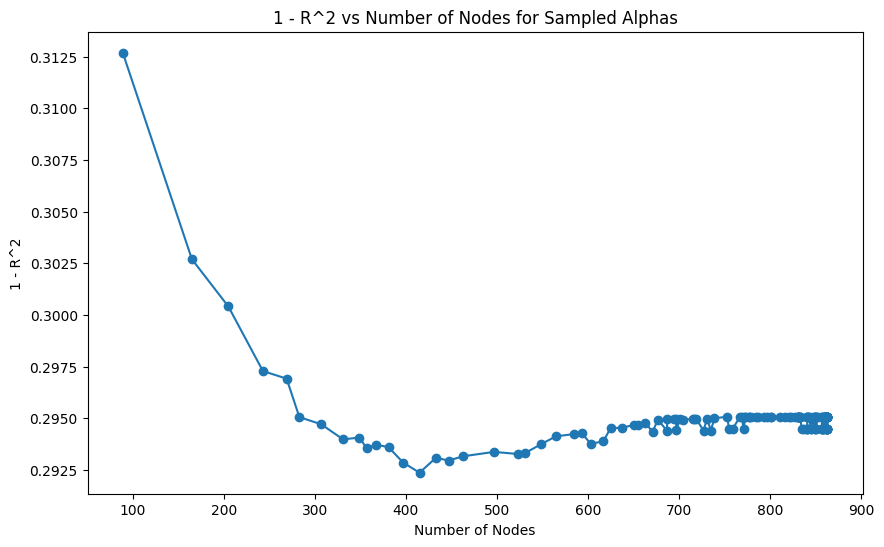

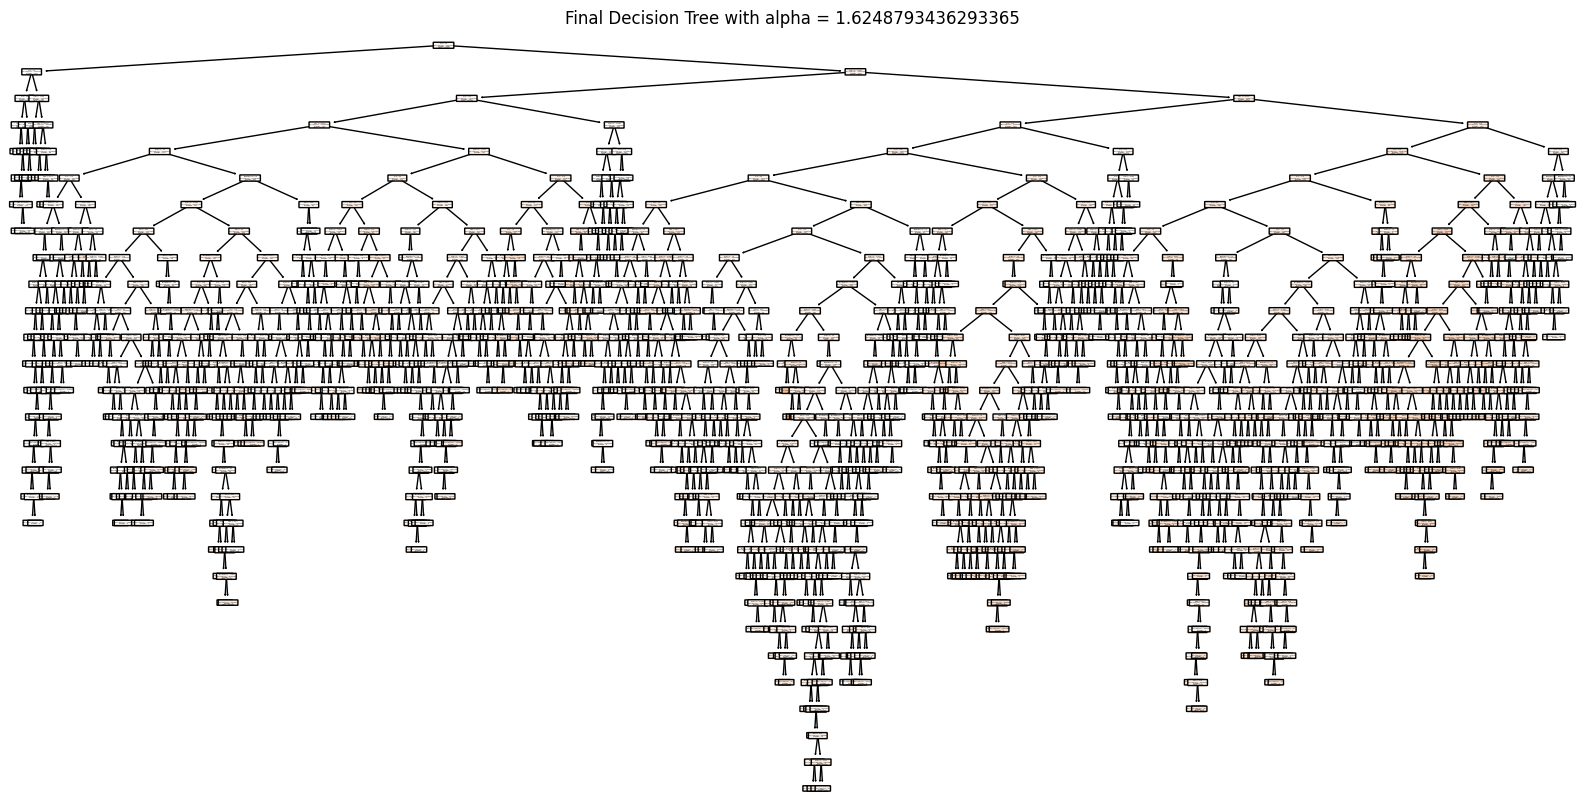

In [33]:
# Plotting 1 - R^2 vs number of nodes for the sampled alphas
node_counts = [
    DecisionTreeRegressor(ccp_alpha=alpha, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split']).fit(X_train, y_train).tree_.node_count
    for alpha in ccp_alphas_sampled
]
one_minus_r2 = [1 - r2_score(y_val, DecisionTreeRegressor(ccp_alpha=alpha, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split']).fit(X_train, y_train).predict(X_val)) for alpha in ccp_alphas_sampled]

plt.figure(figsize=(10, 6))
plt.plot(node_counts, one_minus_r2, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('1 - R^2')
plt.title('1 - R^2 vs Number of Nodes for Sampled Alphas')
plt.show()


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train the final model using alpha = 0.047 for optimal generalization
optimal_alpha = 1.6248793436293365
final_tree = DecisionTreeRegressor(ccp_alpha=optimal_alpha, random_state=42)
final_tree.fit(X_train, y_train)

# Visualize the final decision tree
plt.figure(figsize=(20, 10))
plot_tree(final_tree, feature_names=['year', 'month', 'day', 'hr', 'temp', 'atemp', 'hum', 'weathersit', 'windspeed'], filled=True, rounded=True)
plt.title(f'Final Decision Tree with alpha = {optimal_alpha}')
plt.show()

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Select features and target variable from the pre-processed train_df
X = train_df[['year', 'month', 'hr', 'temp', 'atemp', 'hum', 'weathersit', 'windspeed']]
y = train_df['cnt']

# Split the data into training and validation sets (80:20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees: 100 to 500
    'max_depth': [40, 50, 60],          # Maximum depth of each tree: 40 to 60
    'min_samples_split': [5, 10, 15],       # Minimum samples required to split a node
    'max_features': ['sqrt', 'log2'],   # Method to select features
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with 2-fold cross-validation and MAPE as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Generate predictions on both the training and validation sets
y_train_pred = best_rf.predict(X_train)
y_val_pred = best_rf.predict(X_val)

# Calculate performance metrics for training and validation sets
metrics = {
    'Best Parameters': grid_search.best_params_,
    'Train R-squared': r2_score(y_train, y_train_pred),
    'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'Validation R-squared': r2_score(y_val, y_val_pred),
    'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
}

# Display the results
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("\nRandom Forest Performance on Training Set:")
print(f"R-squared: {metrics['Train R-squared']}")
print(f"MAPE: {metrics['Train MAPE']}\n")

print("Random Forest Performance on Validation Set:")
print(f"R-squared: {metrics['Validation R-squared']}")
print(f"MAPE: {metrics['Validation MAPE']}")

Best Parameters from Grid Search: {'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}

Random Forest Performance on Training Set:
R-squared: 0.9188033037035547
MAPE: 0.5123074143606391

Random Forest Performance on Validation Set:
R-squared: 0.7411775336024409
MAPE: 0.8884112063079069


### Gradient Boosted Trees

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Assume train_df is pre-loaded with the required data
train_df['dteday'] = pd.to_datetime(train_df['dteday'])
train_df['year'] = train_df['dteday'].dt.year
train_df['month'] = train_df['dteday'].dt.month
train_df['day'] = train_df['dteday'].dt.day

# Prepare features and target variable
X = train_df[['year', 'month', 'day', 'hr', 'temp', 'atemp', 'hum', 'weathersit', 'windspeed']]
y = train_df['cnt']

# Split the data into training and validation sets (80:20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages: 50 to 200
    'max_depth': [5, 10, 15],             # Maximum depth of individual trees: 5 to 15
    'learning_rate': [0.1],               # Learning rate
}

# Initialize the gradient boosting regressor
gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_gbr = grid_search.best_estimator_

# Make predictions on the training set and validation set
y_train_pred = best_gbr.predict(X_train)
y_val_pred = best_gbr.predict(X_val)

# Calculate R-squared and MAPE on the training set
rsq_train_gbr = r2_score(y_train, y_train_pred)
mape_train_gbr = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate R-squared and MAPE on the validation set
rsq_val_gbr = r2_score(y_val, y_val_pred)
mape_val_gbr = mean_absolute_percentage_error(y_val, y_val_pred)

# Report the results
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("\nGradient Boosting Tree Performance on Training Set:")
print(f"R-squared: {rsq_train_gbr}")
print(f"MAPE: {mape_train_gbr}\n")

print("Gradient Boosting Tree Performance on Validation Set:")
print(f"R-squared: {rsq_val_gbr}")
print(f"MAPE: {mape_val_gbr}")

Best Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

Gradient Boosting Tree Performance on Training Set:
R-squared: 0.9883301565726514
MAPE: 0.21286522791989423

Gradient Boosting Tree Performance on Validation Set:
R-squared: 0.7495819789232776
MAPE: 0.7775926702298311


### APPLY on Test Set

**1.	Decision Tree:**
- Train R-squared: 0.7751, Validation R-squared: 0.7077
- Train MAPE: 0.8684, Validation MAPE: 0.9222
- Key Takeaway: The decision tree shows moderate fit and accuracy, with higher validation MAPE compared to the other models, suggesting it may struggle with generalization.

**2.	Random Forest:**
- Train R-squared: 0.9188, Validation R-squared: 0.7412
- Train MAPE: 0.5123, Validation MAPE: 0.8884
- Key Takeaway: The random forest model performs better than the decision tree, with lower MAPE values and higher R-squared on both the training and validation sets, indicating stronger predictive power and stability.

**3.	Gradient Boosting Tree (Selected):**
- Train R-squared: 0.9883, Validation R-squared: 0.7496
- Train MAPE: 0.2129, Validation MAPE: 0.7776
- Key Takeaway: GBT achieves the highest R-squared on both training (0.9883) and validation sets (0.7496) with the lowest validation MAPE (0.7776), indicating a very strong fit and generalization. Although GBT has a high training R-squared, the relatively low validation MAPE compared to other models shows it balances accuracy and overfitting better than the decision tree and random forest.

**[Selection Rationale for Gradient Boosting Tree]**

The Gradient Boosting Tree is selected because it achieves the best balance between model fit and generalization. Its low validation MAPE (0.7776) and high R-squared (0.7496) suggest that it effectively captures the underlying patterns in the data with minimal overfitting. GBT’s boosting technique helps correct errors iteratively, leading to improved predictive accuracy on both training and validation sets, making it the optimal choice among the three models.

In [51]:
# Already load and handle missing values in test data set
# Preprocess test data similarly to train_df
test_df['dteday'] = pd.to_datetime(test_df['dteday'])
test_df['year'] = test_df['dteday'].dt.year
test_df['month'] = test_df['dteday'].dt.month
test_df['day'] = test_df['dteday'].dt.day

# Prepare test features (X_test) and target variable (y_test)
X_test = test_df[['year', 'month', 'day', 'hr', 'temp', 'atemp', 'hum', 'weathersit', 'windspeed']]
y_test = test_df['cnt']

# Make predictions on the test set
y_test_pred = best_gbr.predict(X_test)

# Calculate R-squared and MAPE on the test set
rsq_test_gbr = r2_score(y_test, y_test_pred)
mape_test_gbr = mean_absolute_percentage_error(y_test, y_test_pred)

# Report the test results
print("\nGradient Boosting Tree Performance on Test Set:")
print(f"R-squared: {rsq_test_gbr}")
print(f"MAPE: {mape_test_gbr}")


Gradient Boosting Tree Performance on Test Set:
R-squared: 0.658640026464171
MAPE: 0.8083992597707663
